# Data Generation Process for Computation Graph Task

In [1]:
import numpy as np
import string
import random

In [2]:
n_funcs = 5 # number of functions
mod_val = 16 # modulo value for numeric values

func_vocab = [f'func{i}' for i in range(1, n_funcs+1)]
var_vocab = list(string.ascii_lowercase) # letters a-z
operand_vocab = [',', '(', ')']
numeric_vocab = [str(i) for i in range(mod_val)]
equal_token = '->'
query_token = '<query>'
answer_token = '<answer>'
eq_sep_token = '<eq_sep>'
sep_token = '<sep>'

# these are "special tokens"
eos_token = '<eos>'
pad_token = '<pad>'
unk_token = '<unk>'

vocab = operand_vocab + func_vocab + var_vocab + numeric_vocab + [equal_token, query_token, answer_token, sep_token]

class Tokenizer():
    def __init__(self, vocab, unk_token=unk_token, pad_token=pad_token, eos_token=eos_token):
        self.vocab = vocab + [unk_token, pad_token, eos_token]

        self.unk_token = unk_token
        self.pad_token = pad_token
        self.eos_token = eos_token

        self.tok2idx = {tok: idx for idx, tok in enumerate(self.vocab)}
        self.idx2tok = {idx: tok for idx, tok in enumerate(self.vocab)}

        self.unk_token_idx = self.tok2idx[self.unk_token]

    def encode_tokens(self, list_tokens):
        return [self.tok2idx.get(tok, self.tok2idx[self.unk_token]) for tok in list_tokens]

    def decode_tokens(self, list_indices):
        return [self.idx2tok.get(idx, self.unk_token) for idx in list_indices]

    def encode_string(self, string, sep=' '):
        return self.encode_tokens(string.split(sep))

tokenizer = Tokenizer(vocab)

In [3]:
# a naive way to randomly sample a computation graph

def sample_computation_graph_example(n_vars, func_degree, verbose=False):

    # first, sample a topological order of variables for computation DAG
    var_top_order = list(np.random.choice(var_vocab, size=n_vars, replace=False))

    edges = [] # for storing edges in DAG
    func_annotations = dict() # for storing function annotations for each variable
    prompt = [] # for storing prompt

    if verbose:
        print(f'topological order of variables in DAG: {var_top_order}')

    for idx, var in enumerate(var_top_order):
        # check if leaf node
        if idx < func_degree: # for now, first func_degree variables are leaf nodes (because too few possible children)
            var_val = np.random.choice(numeric_vocab)
            edges.append((var_val, var))
            func_annotations[var] = "leafValueAssignment"
            prompt += [var_val, equal_token, var, eq_sep_token]
            if verbose:
                print(f'{var} <- {var_val}')
        # if not leaf node, children are randomly chosen from preceeding variables (wrt topological order)
        # node is a randomly-selected function of its children
        else:
            # randomly sample children from preceeding variables
            children = np.random.choice(var_top_order[:idx], size=func_degree, replace=False).tolist()

            # randomly sample function
            func = np.random.choice(func_vocab)
            func_annotations[var] = func

            for child in children:
                edges.append((child, var))

            prompt += [func, '('] + list(','.join(children)) + [')'] + [equal_token, var, eq_sep_token]

            if verbose:
                print(f'{var} <- {func}({", ".join(children)})')

    if verbose:
        print()
        print(f"prompt: {' '.join(prompt)}")

    return dict(prompt=prompt, edges=edges, func_annotations=func_annotations, var_top_order=var_top_order)

In [4]:
n_vars = 6
func_degree = 2 # for now, all functions have same degree

sample = sample_computation_graph_example(n_vars, func_degree, verbose=True)
prompt, edges, func_annotations, var_top_order = sample['prompt'], sample['edges'], sample['func_annotations'], sample['var_top_order']

topological order of variables in DAG: ['e', 'x', 'b', 'c', 'r', 'i']
e <- 4
x <- 9
b <- func5(e, x)
c <- func4(e, x)
r <- func5(b, x)
i <- func1(x, e)

prompt: 4 -> e <eq_sep> 9 -> x <eq_sep> func5 ( e , x ) -> b <eq_sep> func4 ( e , x ) -> c <eq_sep> func5 ( b , x ) -> r <eq_sep> func1 ( x , e ) -> i <eq_sep>


is DAG: True


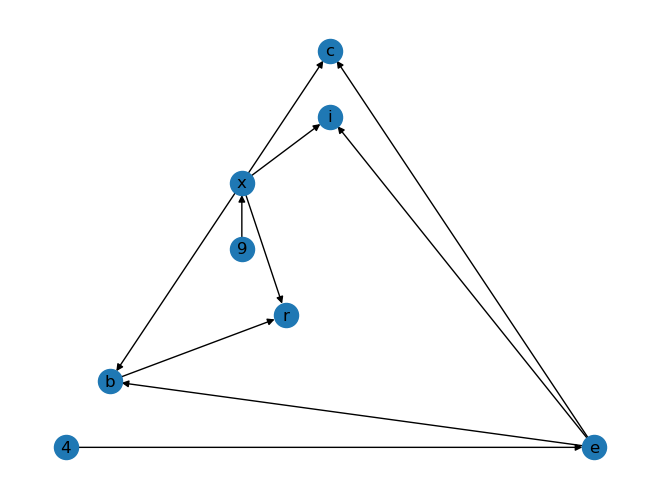

In [5]:
# draw
import networkx as nx

G = nx.from_edgelist(edges, create_using=nx.DiGraph)
nx.set_node_attributes(G, func_annotations, 'func')
print(f'is DAG: {nx.is_directed_acyclic_graph(G)}')

nx.draw_planar(G, with_labels=True, )

In [6]:
import matplotlib.pyplot as plt

In [7]:
# draw DAG according to topological order

def draw_topological_order(G, top_order, rad=-0.8, figsize=(8,4), orientation='horizontal'):
    numeric_nodes = [node for node in G.nodes() if node in numeric_vocab]
    top_order = numeric_nodes + top_order

    if orientation == 'horizontal':
        pos = {node:(top_order.index(node),0) for node in G.nodes()}
    else:
        pos = {node:(0,top_order.index(node)) for node in G.nodes()}

    fig, ax = plt.subplots(figsize=figsize)
    for edge in G.edges():
        source, target = edge
        rad = 0.8
        rad = rad if top_order.index(source)%2 else -rad
        ax.annotate("",
                    xy=pos[source],
                    xytext=pos[target],
                    arrowprops=dict(arrowstyle="->", color="black",
                                    connectionstyle=f"arc3,rad={rad}",
                                    alpha=0.6,
                                    linewidth=1.5))
    nx.draw_networkx_nodes(G, pos=pos, node_size=500, node_color='black')
    nx.draw_networkx_labels(G, pos=pos, font_color='white')
    plt.box(False)
    return fig, ax


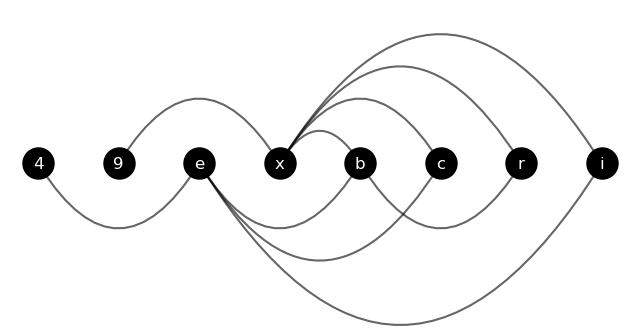

In [8]:
fig, ax = draw_topological_order(G, var_top_order)

# generate prompt from graph

In [9]:
n_vars = 6
func_degree = 2 # for now, all functions have same degree

sample = sample_computation_graph_example(n_vars, func_degree, verbose=True)
prompt, edges, func_annotations, var_top_order = sample['prompt'], sample['edges'], sample['func_annotations'], sample['var_top_order']

topological order of variables in DAG: ['q', 'f', 's', 'b', 'r', 'm']
q <- 7
f <- 0
s <- func1(q, f)
b <- func4(s, q)
r <- func4(q, b)
m <- func1(f, b)

prompt: 7 -> q <eq_sep> 0 -> f <eq_sep> func1 ( q , f ) -> s <eq_sep> func4 ( s , q ) -> b <eq_sep> func4 ( q , b ) -> r <eq_sep> func1 ( f , b ) -> m <eq_sep>


In [10]:
G.nodes()

NodeView(('4', 'e', '9', 'x', 'b', 'c', 'r', 'i'))

In [11]:
func_map = {func: lambda children: sum(children) % mod_val for func in func_vocab} # NOTE: for now, all functions are sums (TODO: generalize)
def leafValueAssignment(children):
    if len(children) == 1:
        return children[0]
    else:
        raise ValueError("leafValueAssignment function should have exactly one child")

func_map['leafValueAssignment'] = lambda x: x[0]

In [12]:
func_map

{'func1': <function __main__.<dictcomp>.<lambda>(children)>,
 'func2': <function __main__.<dictcomp>.<lambda>(children)>,
 'func3': <function __main__.<dictcomp>.<lambda>(children)>,
 'func4': <function __main__.<dictcomp>.<lambda>(children)>,
 'func5': <function __main__.<dictcomp>.<lambda>(children)>,
 'leafValueAssignment': <function __main__.<lambda>(x)>}

In [13]:
def solve_sample(sample, func_map, verbose=False):
    edges = sample['edges']
    func_annotations = sample['func_annotations']
    var_top_order = sample['var_top_order']

    G = nx.from_edgelist(edges, create_using=nx.DiGraph)
    nx.set_node_attributes(G, func_annotations, 'func')
    node_vals = {node: int(node) if node in numeric_vocab else None for node in G.nodes()}
    nx.set_node_attributes(G, node_vals, 'val')

    if verbose:
        print('initializing node values:')
        print(node_vals)
        print()
        print('now iterating in topological order and solving for the value of each node...')
        print()

    for var in var_top_order:
        children = list(G.predecessors(var)) # NOTE: unintuitively (for me), predecessors are children in this context
        par_vals = [node_vals[child] for child in children]
        if verbose:
            print(f'Children({var}) = {[f"{p}={pv}" for p, pv in zip(children, par_vals)]}')
        func_name = func_annotations[var]
        func = func_map[func_name]
        node_vals[var] = func(par_vals)
        if verbose:
            print(f'{var} <- {func_name}({[node_vals[child] for child in children]}) = {node_vals[var]}')
            print()

    sample['node_vals'] = node_vals

In [14]:
solve_sample(sample, func_map, verbose=True)
sample['node_vals']

initializing node values:
{'7': 7, 'q': None, '0': 0, 'f': None, 's': None, 'b': None, 'r': None, 'm': None}

now iterating in topological order and solving for the value of each node...

Children(q) = ['7=7']
q <- leafValueAssignment([7]) = 7

Children(f) = ['0=0']
f <- leafValueAssignment([0]) = 0

Children(s) = ['q=7', 'f=0']
s <- func1([7, 0]) = 7

Children(b) = ['s=7', 'q=7']
b <- func4([7, 7]) = 14

Children(r) = ['q=7', 'b=14']
r <- func4([7, 14]) = 5

Children(m) = ['f=0', 'b=14']
m <- func1([0, 14]) = 14



{'7': 7, 'q': 7, '0': 0, 'f': 0, 's': 7, 'b': 14, 'r': 5, 'm': 14}

In [15]:
''.join(prompt)

'7->q<eq_sep>0->f<eq_sep>func1(q,f)->s<eq_sep>func4(s,q)->b<eq_sep>func4(q,b)->r<eq_sep>func1(f,b)->m<eq_sep>'

In [16]:
def create_query_prompt(sample, tokenizer_func=None, verbose=False):
    query_prompt = sample['prompt'].copy()
    node_vals = sample['node_vals']
    var_top_order = sample['var_top_order']

    query_var = var_top_order[-1] # either last var in computation graph or randomly sample from vars

    query_prompt += [query_token, query_var, answer_token, str(node_vals[query_var])]

    if verbose:
        print(' '.join(prompt))

    sample['query_prompt'] = query_prompt
    if tokenizer_func is not None:
        sample['tokenized_query_prompt'] = tokenizer_func(query_prompt)

In [17]:
create_query_prompt(sample, tokenizer_func=tokenizer.encode_tokens, verbose=True)
sample['query_prompt']

7 -> q <eq_sep> 0 -> f <eq_sep> func1 ( q , f ) -> s <eq_sep> func4 ( s , q ) -> b <eq_sep> func4 ( q , b ) -> r <eq_sep> func1 ( f , b ) -> m <eq_sep>


['7',
 '->',
 'q',
 '<eq_sep>',
 '0',
 '->',
 'f',
 '<eq_sep>',
 'func1',
 '(',
 'q',
 ',',
 'f',
 ')',
 '->',
 's',
 '<eq_sep>',
 'func4',
 '(',
 's',
 ',',
 'q',
 ')',
 '->',
 'b',
 '<eq_sep>',
 'func4',
 '(',
 'q',
 ',',
 'b',
 ')',
 '->',
 'r',
 '<eq_sep>',
 'func1',
 '(',
 'f',
 ',',
 'b',
 ')',
 '->',
 'm',
 '<eq_sep>',
 '<query>',
 'm',
 '<answer>',
 '14']